THD (100 Hz): 1.18%
THD (1100 Hz): 0.09%
THD (2100 Hz): 0.09%
THD (3100 Hz): 0.06%
THD (4100 Hz): 0.39%
THD (5100 Hz): 0.36%
THD (6100 Hz): 1.28%
THD (7100 Hz): 0.27%
THD (8100 Hz): 0.08%
THD (9100 Hz): 0.04%
THD (10100 Hz): 0.07%


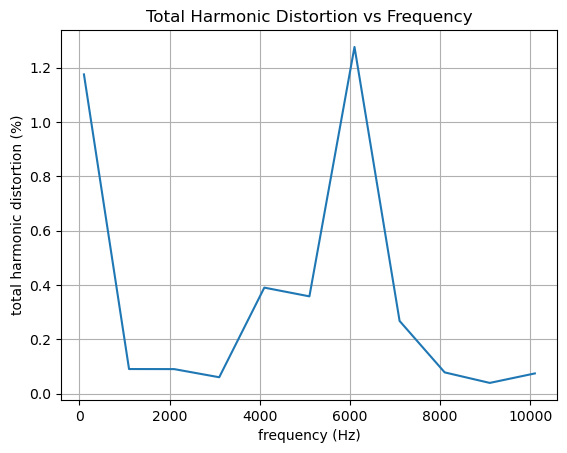

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import sys
import pyaudio
import sounddevice as sd
# from thd import thd
from scipy.io import savemat

# Generate tone
# fc_approx = 8000 # approximate fc, will choose fc to be a factor of fs, will analyze 1 second of data, so this should be an integer
fs = 44.1e3
fundFreqNotchWidthFrac = .1 # width of the brick wall notch filter in frequency domain when measuring distortion expressed as a fraction of the fundamental frequency
fundFreqSearchWidthFract = .01 # width of the range to search for max amplitude relative to fundamental frequency
debugOn = False

freqsToTest =  np.arange(100,fs/4,100) #np.array([7100]) #np.arange(100,fs/4,1000) #
thdAll = np.zeros(freqsToTest.shape)

for freqIdx in range(0,len(freqsToTest)):
    fc = freqsToTest[freqIdx]
    # fc = fs/round(fs/fc_approx)
    # bufferSize = 512
    duration = 1.5 # in seconds
    toneAmplitude = 1 # gain factor
    t = np.arange(0,duration,1/fs)
    signalOrig = toneAmplitude * np.sin(2*math.pi*fc*t)
    # tone1 = toneAmplitude * np.sin(2*math.pi*fc*1*t)
    # tone2 = toneAmplitude * np.sin(2*math.pi*fc*2*t)
    # tone3 = toneAmplitude * np.sin(2*math.pi*fc*3*t)
    # signalOrig = tone1 + tone2 + tone3
    
    # # Add synthetic distortion
    # maxHarmonic = math.floor(fs/2/fc)
    # harmonicCoeff = 1e-4*np.random.rand(maxHarmonic-1)

    # signalDistortions = np.zeros(signalOrig.shape)
    # for harmNum in range(2,maxHarmonic):
    #     signalDistortions = signalDistortions + harmonicCoeff[harmNum-2]*np.sin(2*math.pi*fc*t*harmNum)

    # signalToAnalyze = signalOrig + signalDistortions

    # Playback and record signal
    signalToAnalyzeRaw = sd.playrec(signalOrig, fs, channels=1)
    sd.wait()
    
    # truncate first 0.5 second of signal to allow for recording delay
    startBuffer = 0.25 # in seconds
    endBuffer = 0.25 # in seconds

    signalToAnalyze = signalToAnalyzeRaw[math.ceil(startBuffer*fs):(len(signalToAnalyzeRaw)-math.ceil(endBuffer*fs))]
    #savemat('recSig.mat',{'y':signalToAnalyze,'fs':fs,'tone1':tone1,'tone2':tone2,'tone3':tone3})

    # measure spectrum
    spectrum = np.fft.rfft(signalToAnalyze,axis=0)
    fftBin = fs/len(signalToAnalyze)
    # freqX = np.arange(-fs/2,fs/2,fftBin)

    
    fcIdxTheoretical = round(fc/fftBin)
    fcOffcenter = fc/fftBin - fcIdxTheoretical

    if fcOffcenter > 1e-3:
        print("DFT bin not centered on carrier frequency. Unexpected results may occur due to spectral leakage.")

    fundFreqSearchWidthHz = fundFreqSearchWidthFract*fc # Hz, width of the brick wall notch filter in frequency domain when measuring distortion
    fundFreqSearchWidthHzSamps = fundFreqSearchWidthHz/fftBin
    fundFreqSearchWidthHzSampsHW = int(np.ceil(fundFreqSearchWidthHzSamps/2)) # round up
    minSearchIdx = int(np.max([0,fcIdxTheoretical-fundFreqSearchWidthHzSampsHW]))
    maxSearchIdx = int(np.min([len(spectrum)-1,fcIdxTheoretical+fundFreqSearchWidthHzSampsHW])) 
    fcIdx = int(minSearchIdx + np.argmax(abs(spectrum[minSearchIdx:maxSearchIdx])))
    # savemat('recSig.mat',{'fundFreqSearchWidthFract':fundFreqSearchWidthFract,'fcIdxTheoretical':fcIdxTheoretical,'freqSpectrum':spectrum,'fs':fs,'minSearchIdx':minSearchIdx,'maxSearchIdx':maxSearchIdx,'fcIdx':fcIdx,'fundFreqSearchWidthHz':fundFreqSearchWidthHz,'fundFreqSearchWidthHzSamps':fundFreqSearchWidthHzSamps,'fundFreqSearchWidthHzSampsHW':fundFreqSearchWidthHzSampsHW})
    if debugOn:
        print(f'Correct fcIdx by %d DFT bins' % (fcIdxTheoretical-fcIdx))
    
    carrierAmpl = abs(spectrum[fcIdx][0])

    if np.mod(len(spectrum),2)==0: # even number of points in spectrum
        lastPosFreqIdx = int((fs/2)/fftBin)
    else: # odd number of points in spectrum
        lastPosFreqIdx = int((fs/2 - fftBin)/fftBin)

    # measure power of all signals other than the fundamental frequency
    spectrumNoFund = spectrum.copy()
    
    # apply "brick wall" notch filter in spectrum (i.e. zero out frequency components around fundamental frequency
    fundFreqNotchWidthHz = fundFreqNotchWidthFrac*fc # Hz, width of the brick wall notch filter in frequency domain when measuring distortion
    fundFreqNotchWidthHzSamps = fundFreqNotchWidthHz/fftBin
    fundFreqNotchWidthHzSampsHW = int(np.ceil(fundFreqNotchWidthHzSamps/2)) # round up
    minNotchIdx = int(np.max([0,fcIdx-fundFreqNotchWidthHzSampsHW]))
    maxNotchIdx = int(np.min([len(spectrumNoFund),fcIdx+fundFreqNotchWidthHzSampsHW]))
    spectrumNoFund[minNotchIdx:maxNotchIdx] = 0
    
    harmonicAmpl = np.sqrt(np.sum(np.square(abs(spectrumNoFund))))
    
    # measure power of harmonics signals of the fundamental frequency
    harmonicIdx = range(2*fcIdx,lastPosFreqIdx,fcIdx)
    harmonicAmpl = np.sqrt(np.sum(np.square(abs(spectrum[harmonicIdx]))))

    measTHD = harmonicAmpl/carrierAmpl*100
    print("THD (%d Hz): %.2f%%" % (fc,measTHD))
    # print("freqIdx: %d" % (freqIdx))
    thdAll[freqIdx] = measTHD
    
    if debugOn:
        # Plot time domain signal
        plt.plot(signalToAnalyze[0:int(10/fc*fs-1)])
        plt.title(f'Recorded Signal %d Hz' % fc)
        plt.xlabel('time (samples)')
        plt.ylabel('magnitude')
        plt.grid(visible=True,which='both',axis='both')
        plt.show()

        # Plot positive frequency spectrum showing fundamental frequency
        freqX = np.fft.fftfreq(len(signalToAnalyze), d=1./fs)
        if np.mod(len(spectrum),2)==0: # even number of points in spectrum
            freqXPos = np.arange(0,int(fs/2),int(fftBin))
        else: # odd number of points in spectrum
            freqXPos = np.arange(0,int(fs/2-fftBin),int(fftBin))
        # plt.plot(freqXPos,abs(spectrum[range(0,len(freqXPos))]))
        # plt.plot(freqXPos[fcIdx],abs(spectrum[fcIdx]),marker="*")
        # plt.plot(freqXPos[harmonicIdx],abs(spectrum[harmonicIdx]),linestyle='None',marker="o")
        plt.plot(freqXPos,20*np.log10(abs(spectrum[range(0,len(freqXPos))])))
        plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrum[fcIdx])),marker="*")
        plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrum[harmonicIdx])),linestyle='None',marker='o')
        plt.title(f'Recorded Signal Spectrum %d Hz' % fc)
        plt.xlabel('frequency (Hz)')
        plt.grid(visible=True,which='both',axis='both')
        plt.show()
        
        # Plot positive frequency spectrum removing fundamental frequency
        # plt.plot(freqXPos,abs(spectrumNoFund[range(0,len(freqXPos))]))
        # plt.plot(freqXPos[fcIdx],abs(spectrumNoFund[fcIdx]),marker="*")
        # plt.plot(freqXPos[harmonicIdx],abs(spectrumNoFund[harmonicIdx]),linestyle='None',marker="o")
        plt.plot(freqXPos,20*np.log10(abs(spectrumNoFund[range(0,len(freqXPos))])))
        plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrumNoFund[fcIdx])),marker="*")
        plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrumNoFund[harmonicIdx])),linestyle='None',marker='o')
        plt.title(f'Recorded Signal Spectrum %d Hz - Fundamental Removed' % fc)
        plt.xlabel('frequency (Hz)')
        plt.grid(visible=True,which='both',axis='both')
        plt.show()
    
    time.sleep(.5)

plt.plot(freqsToTest,thdAll)
plt.title('Total Harmonic Distortion vs Frequency')
plt.xlabel('frequency (Hz)')
plt.ylabel('total harmonic distortion (%)')
plt.grid(visible=True,which='both',axis='both')

